# Clothing Vec to Shoe Vec Training

In [1]:
import keras
from keras.layers import Input, Dense, Dot, Softmax
from keras.models import Model
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.utils import shuffle

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
# create a lookup vector dictionary for clothing and shoes
clothing_df = pd.read_pickle('saved_models/dense_clothing_df.pickle')
shoe_df = pd.read_pickle('saved_models/dense_shoe_df_aws.pickle')
shoe_df.index = pd.Series(shoe_df.index).apply(lambda x: '../' + x)

clothing_dim = clothing_df.shape[1]
shoe_dim = shoe_df.shape[1]

clothing_dict = {}
for idx in clothing_df.index:
    clothing_dict[idx] = np.array(clothing_df.loc[idx]).reshape(1, clothing_dim)
    
shoe_dict = {}
for idx in shoe_df.index:
    shoe_dict[idx] = np.array(shoe_df.loc[idx]).reshape(1, shoe_dim)

In [3]:
link_df = pd.read_csv('../data/links.txt')
link_df = link_df.dropna().reset_index(drop=True)
print(link_df.shape)
link_df.head()

(5488, 3)


,clothing_path,shoe_path,response
0,../data/clothing2/train/light_blue_short_dress...,../data/shoes/train/athletic/8140605.151.jpg,0
1,../data/clothing2/train/brown_suede_jackets/br...,../data/shoes/train/knee_boots/7347958.281.jpg,0
2,../data/clothing2/validate/long_sleeve_tops/lo...,../data/shoes/train/ankle_boots/8112971.72.jpg,1
3,../data/clothing2/train/white_pants/white_pant...,../data/shoes/test/sandals/7505095.6.jpg,1
4,../data/clothing2/train/spring_floral_dresses/...,../data/shoes/train/sandals/8081068.4535.jpg,0


In [7]:
def get_dataset(df, dictionary, c_or_s):
    assert (c_or_s == 'c' or c_or_s == 's')
    if c_or_s == 'c':
        array = np.empty(shape=(0, clothing_dim))
        path = 'clothing_path'
    else:
        array = np.empty(shape=(0, shoe_dim))
        path = 'shoe_path'
    
    for i in range(df.shape[0]):
        try:
            array = np.append(array, dictionary[df[path][i]], axis=0)
        except KeyError:
            print(df[path][i])
        
    return array

In [8]:
link_df = shuffle(link_df)
split1 = int(link_df.shape[0]*0.8)
split2 = int(link_df.shape[0]*0.9)

train_paths = link_df.iloc[0:split1].reset_index(drop=True)
valid_paths = link_df.iloc[split1:split2].reset_index(drop=True)
test_paths = link_df.iloc[split2:].reset_index(drop=True)

train_cloth_vecs = get_dataset(train_paths, clothing_dict, 'c')
valid_cloth_vecs = get_dataset(valid_paths, clothing_dict, 'c')
test_cloth_vecs = get_dataset(test_paths, clothing_dict, 'c')

train_shoe_vecs = get_dataset(train_paths, shoe_dict, 's')
valid_shoe_vecs = get_dataset(valid_paths, shoe_dict, 's')
test_shoe_vecs = get_dataset(test_paths, shoe_dict, 's')

train_targets = np.array(link_df['response'].iloc[0:split1])
valid_targets = np.array(link_df['response'].iloc[split1:split2])
test_targets = np.array(link_df['response'].iloc[split2:])

**Transform the clothing vector space into shoe vector space**

In [9]:
clothing_input = Input(shape=[clothing_dim], name='clothing_input')
clothing_transform = Dense(shoe_dim, activation='linear', name='clothing_to_shoe')(clothing_input)

shoe_input = Input(shape=[shoe_dim], name='shoe_input')

prod = Dot(axes=1, name='DotProduct', normalize=True)([clothing_transform, shoe_input])
pred = Dense(1, name='Prediction',  activation='sigmoid')(prod)

model = Model(inputs=[clothing_input, shoe_input], outputs=[pred])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
clothing_input (InputLayer)     (None, 300)          0                                            
__________________________________________________________________________________________________
clothing_to_shoe (Dense)        (None, 300)          90300       clothing_input[0][0]             
__________________________________________________________________________________________________
shoe_input (InputLayer)         (None, 300)          0                                            
__________________________________________________________________________________________________
DotProduct (Dot)                (None, 1)            0           clothing_to_shoe[0][0]           
                                                                 shoe_input[0][0]                 
__________

In [10]:
model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])

In [11]:
epochs = 30

early_stop = EarlyStopping(monitor='val_loss', patience=3)
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.vector_links.hdf5', 
                               verbose=1, save_best_only=True)

history = model.fit([train_cloth_vecs, train_shoe_vecs], train_targets, epochs=epochs, 
                    validation_data=([valid_cloth_vecs, valid_shoe_vecs], valid_targets),
                    verbose=1, callbacks=[checkpointer, early_stop])

Train on 4390 samples, validate on 549 samples
Epoch 1/30
4390/4390 [==============================] - 1s 335us/step - loss: 0.5633 - acc: 0.7253 - val_loss: 0.5069 - val_acc: 0.7851

Epoch 00001: val_loss improved from inf to 0.50695, saving model to saved_models/weights.best.vector_links.hdf5
Epoch 2/30
4390/4390 [==============================] - 1s 244us/step - loss: 0.5258 - acc: 0.7585 - val_loss: 0.4886 - val_acc: 0.7978

Epoch 00002: val_loss improved from 0.50695 to 0.48857, saving model to saved_models/weights.best.vector_links.hdf5
Epoch 3/30
4390/4390 [==============================] - 1s 244us/step - loss: 0.5125 - acc: 0.7640 - val_loss: 0.4820 - val_acc: 0.7978

Epoch 00003: val_loss improved from 0.48857 to 0.48196, saving model to saved_models/weights.best.vector_links.hdf5
Epoch 4/30
4390/4390 [==============================] - 1s 246us/step - loss: 0.5014 - acc: 0.7704 - val_loss: 0.4755 - val_acc: 0.7887

Epoch 00004: val_loss improved from 0.48196 to 0.47553, savin

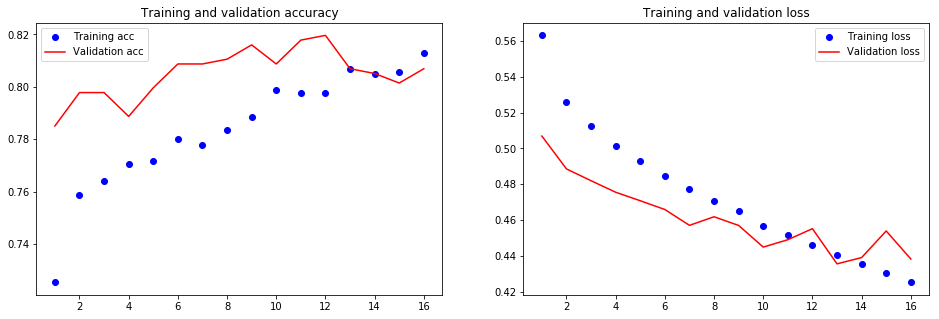

In [12]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc', c='r')
plt.title('Training and validation accuracy')
plt.legend()
plt.subplot(1,2,2)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss', c='r')
plt.title('Training and validation loss')
plt.legend();

In [13]:
# get index of predicted item for each image in test set
predictions = model.predict([test_cloth_vecs, test_shoe_vecs])
predictions[:] = predictions[:] > 0.499999999
predictions = predictions.reshape(1, -1)
test_accuracy = 100*np.sum(predictions==test_targets) / predictions.shape[1]
test_accuracy

79.41712204007285

**Get the transformation from clothing space to shoe space**

In [14]:
dress_to_shoe_transform = Model(inputs=[clothing_input], outputs=[clothing_transform])

In [15]:
dress_to_shoe_transform.predict(train_cloth_vecs).shape

(4390, 300)

In [16]:
model.get_layer(name='Prediction').get_weights()

[array([[-3.3961353]], dtype=float32), array([-0.60813355], dtype=float32)]

In [17]:
dress_to_shoe_transform.save('saved_models/dress2shoe_aws.h5')
dress_to_shoe_transform.save_weights('saved_models/dress2shoe_weights_aws.hdf5')